In [20]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale

locale.setlocale(locale.LC_TIME,'fr_FR.utf8')
label_fontsize = 18


def build_data():
    
    my_df = pd.read_excel("23-24.ods", sheet_name="Journal",header=4, index_col=3,
                 parse_dates=True)
    pd.set_option('expand_frame_repr', False)
    pd.set_option('display.max_rows', None)
    
    my_df.drop(my_df.columns[[0,1,2,3,8,10,11,12,13,14,15,16,17]], axis=1, inplace=True)
    my_df.dropna(inplace=True)
    alldays_idx = pd.date_range(start=my_df.index[0], end=my_df.index[-1], freq='D')
    df_reindexed = my_df.reindex(alldays_idx)
   
    return df_reindexed


def summarize(my_df):
    """
    From a dataframe with dates and kilometers,
    insert a new column with km sum by week
    """

    my_df = build_data()
    
    # Insert two new columns: week and month (with year)
    my_df["week"] =  pd.to_datetime(my_df.index).strftime('%Y-%W')
    # my_df["month"] =  pd.to_datetime(my_df.index).strftime('%Y-%m')

    
    # print(my_df.groupby('month')['km'].sum())
    week_sum = my_df.groupby('week' ).agg({"km": "sum"})

    
    week_sum.set_index(pd.to_datetime(week_sum.index+'6', format="%Y-%W%w"), inplace=True)
    
    my_df["week_sum"] = week_sum
    return my_df


my_df = summarize(build_data())
print(my_df.columns)




Index(['type', 'km', 'temps', 'elev', 'moy', 'week', 'week_sum'], dtype='object')


In [31]:
my_df = summarize(build_data())


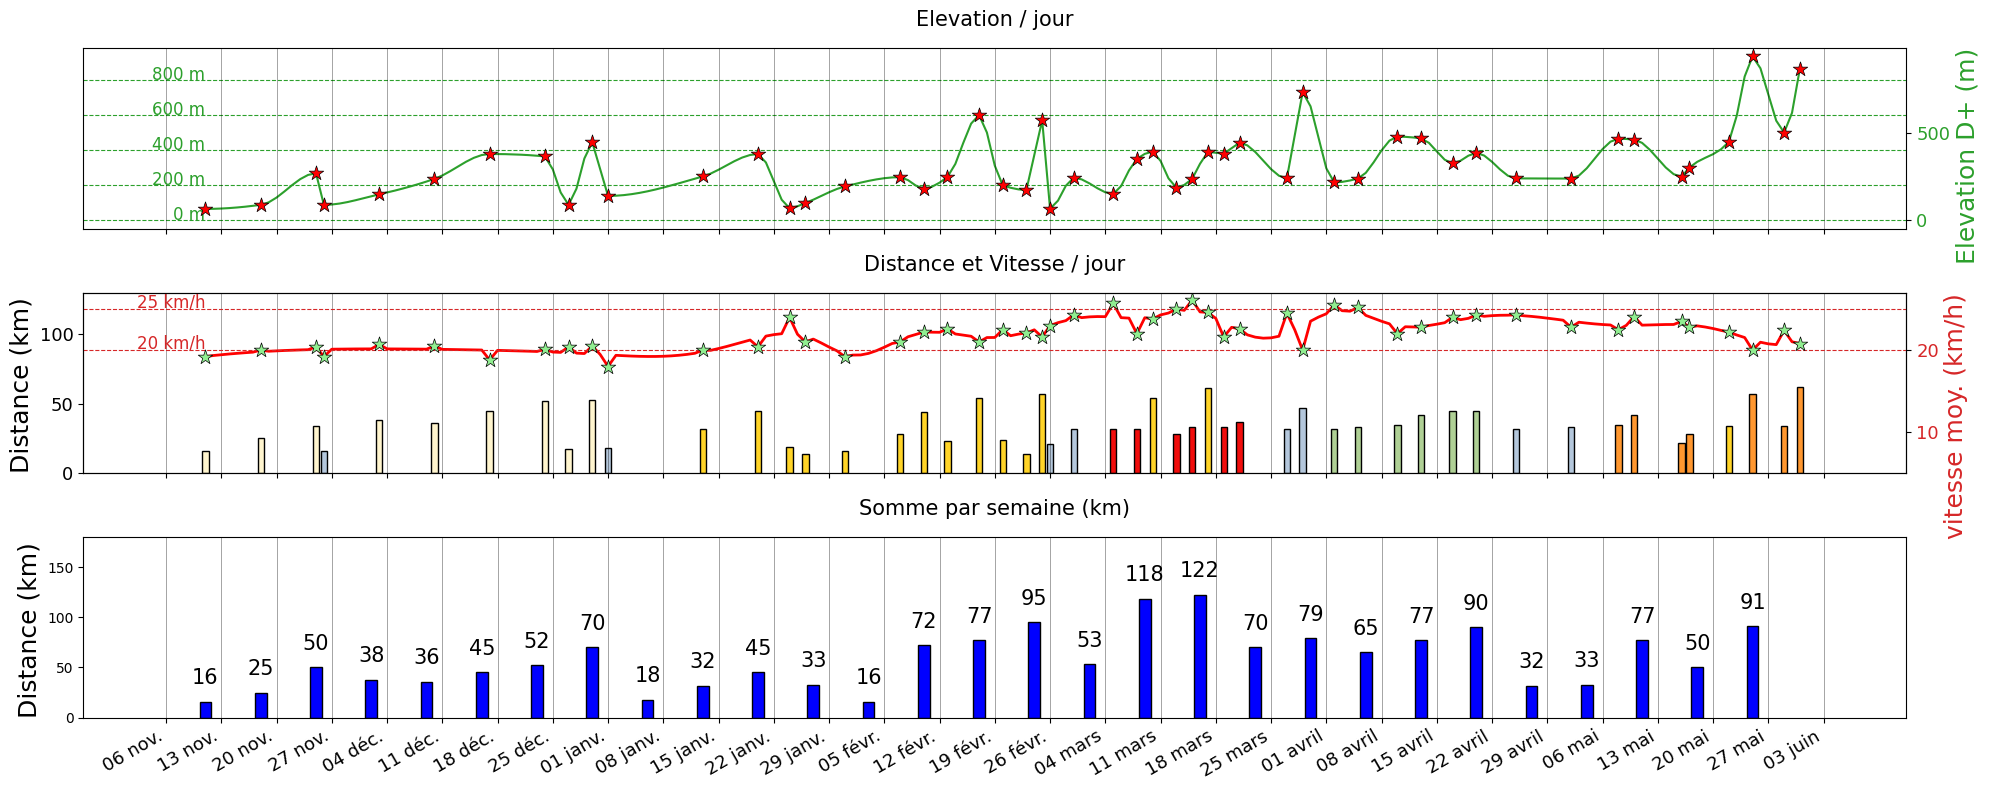

In [44]:
def show_resume(my_df):
    import datetime
    import matplotlib.dates as mdates
    import locale
    
    km_df = my_df['km']
    moy_df = my_df['moy']
    type_df = my_df['type']
    elev_df = my_df['elev']
    kmsum_df = my_df['week_sum']

    num_plots = 3
    
    locale.setlocale(locale.LC_TIME,'fr_FR.utf8')
    
    label_fontsize = 18
    bar_color = "black"
    moy_color = "red"
    block_types = {"foncier": "#fff5ce",
                   "conso": "#ffd428",
                   "recup": "#b4c7dc",
                    "hiit": "#f10d0c",
                    "spec": "#afd095",
                    "deniv": "#ff972f",
                    "course": "#009900"}
    
    monday_start = km_df.index[0] - datetime.timedelta(weeks=1)
    monday_stop = km_df.index[-1] + datetime.timedelta(weeks=1)
    monday_idx = pd.date_range(start=monday_start, end=monday_stop, freq=pd.offsets.Week(weekday=0))
    
    # print(moy_df)
    fig, ax = plt.subplots(num_plots, figsize=(20,8), sharex=True)

    # Show Elevation
    elev_color = 'tab:green'
    ax0 = ax[0]
    ax0.set_title("Elevation / jour", y=1.0, pad=16)
    ax0.title.set_size(15)
    ax0.set_ylabel("Elevation D+ (m)", color=elev_color, fontsize=label_fontsize, loc="top")
    ax0.tick_params(axis='y', labelcolor=elev_color, labelsize=label_fontsize-5)
    ax0.yaxis.tick_right()
    ax0.yaxis.set_label_position("right")
    
    for _hl in [0, 200, 400, 600, 800]:
        ax0.text(elev_df.index[0], _hl+0.2, f"{_hl} m", color=elev_color, fontsize=12, horizontalalignment="right")
        ax0.axhline( _hl, color = elev_color, lw=0.8,  alpha=1, linestyle = '--') 

 
    # ax0.set_ylim([-4000, 1000])
    ax0.plot(elev_df.index, elev_df.interpolate(method="pchip", order=5), color=elev_color)
    ax0.scatter(elev_df.index, elev_df, marker="*", zorder=3, color="red", edgecolor="black", lw=0.5, s=120)
    # show start of weeks
    for monday in monday_idx:
        ax0.axvline(monday,color='black', lw=0.5, alpha=0.5, linestyle='-')


    
    # ax0.set_ylim([0, 1000])

    ax1 = ax[1]

    ax1.set_title("Distance et Vitesse / jour", y=1.0, pad=16)
    ax1.title.set_size(15)
    ax1.set_ylim([0, 130])

    
    # ax1.set_xlabel("Lundis", fontsize=label_fontsize, labelpad=5.0, loc="left")

    # Different bar color depending on block type
    for type, type_color in block_types.items():
        mask_type = type_df == type
        km_index = km_df.index[mask_type]
        km_values = km_df[mask_type]
        bar_container = ax1.bar(km_index,km_values , color=type_color, width=0.8, edgecolor="black")


    ax1.set_ylabel("Distance (km)", color=bar_color, fontsize=label_fontsize, loc="bottom")
    ax1.tick_params(axis='y', labelcolor=bar_color, labelsize=label_fontsize-5)

    # Show start of weeks as V-line
    for monday in monday_idx:
        ax1.axvline(monday,color='black', lw=0.5, alpha=0.5, linestyle='-')
        

    # Show mean speed as a red spline line with stars for each value
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim([5, 27])
    color = 'tab:red'
    for _hl in [20, 25]:
        ax2.text(moy_df.index[0], _hl+0.2, f"{_hl} km/h", color=color, fontsize=12, horizontalalignment="right")
        ax2.axhline( _hl, color = color, lw=0.8,  alpha=1, linestyle = '--') 
    
    ax2.set_ylabel('vitesse moy. (km/h)', color=color, fontsize=label_fontsize, loc="top")  # we already handled the x-label with ax1
    ax2.plot(moy_df.index, moy_df.interpolate(method="spline", order=5 ), color="red", lw=2, zorder=-4)
    # ax2.plot(moy_df.index, moy_df, color="red", lw=2, zorder=-4)
    ax2.scatter(moy_df.index, moy_df, marker="*", zorder=3, color="lightgreen", edgecolor="black", lw=0.5, s=120)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=label_fontsize-5)


    ax3 = ax[2]
    
    ax3.set_title("Somme par semaine (km)", y=1.0, pad=16)
    ax3.title.set_size(15)

    bar_container = ax3.bar(kmsum_df.index, kmsum_df, color='blue', width=1.5, zorder=2, edgecolor="black")

    
    ax3.bar_label(bar_container, label_type="edge", padding=10, zorder=8, color="black", fontsize=15)
    # show start of weeks
    for monday in monday_idx:
        ax3.axvline(monday,color='black', lw=0.5, alpha=0.5, linestyle='-')
        
    ax3.set_ylim([0, 180])

    # Set x ticks
    date_format = '%d %b'
    ax3.tick_params(axis='x', labelsize=label_fontsize-5, rotation=30)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax3.set_xticks(monday_idx)
    ax3.set_xticklabels (ax3.get_xticklabels(), ha="right")
    ax3.set_ylabel("Distance (km)", color=bar_color, fontsize=label_fontsize, loc="bottom")
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

show_resume(my_df)

In [40]:

def show_max_min_sum(km_df):
    
    
    # Reindex by week num
    km_w = km_df.copy()
    km_w.index = pd.to_datetime(km_w.index, format = '%Y-%m-%d').strftime('%W')
    var = km_w.groupby(by=km_w.index).sum()
    
    
    
    km_w = km_df.to_frame()
    km_w["w_num"] = km_w.index.strftime("%W")
    km_w_sum = km_w.groupby(by=km_w["w_num"], sort=False).agg("sum")
    km_w_mean = km_w.groupby(by=km_w["w_num"], sort=False).agg("mean")
    km_w_max = km_w.groupby(by=km_w["w_num"], sort=False).agg("max")
    
    figures_meta =[
        {"title": "Somme / semaine (km)",
         "data": km_w_sum.km,
         "xlabel": "num semaine",
         "hlines": [20, 60, 120],
         "bl_color": "black",
         "color": "orange"},
        {"title": "Moyenne / semaine (km)",
         "data": km_w_mean.km,
         "xlabel": "num semaine",
         "hlines": [20, 40, 50],
         "bl_color": "white",
         "color": "green"},
        {"title": "Sortie maximale / semaine (km)",
         "xlabel": "num semaine",
         "hlines": [20, 50, 60],
         "bl_color": "blue",
         "data": km_w_max.km,
         "color": "red"},
    ]
    

    
    fig, ax = plt.subplots(len(figures_meta),  figsize=(20,15), sharey=False)
    fig.tight_layout(pad=10.0)
    for i, _meta in enumerate(figures_meta):
        # from matplotlib import dates as mdates
        # ax2=ax[i].twiny(ValueError: Cannot use '%W' or '%U' without day and year)
        # ax2.xaxis.set_major_locator(mdates.MonthLocator())
        # ax2.xaxis.set_major_locator(mdates.MonthLocator())kjj
        # ax2.set_ylabel('Month', color="blue", fontsize=label_fontsize)  # we already handled the x-label with ax1
        # ax2.plot(new_idx)
        # ax2.scatter(moy_reindexed.index, moy_reindexed, zorder=3, color="green", edgecolor="black", lw=0.5, s=120)
        # ax2.tick_params(axis='y', labelcolor=color, labelsize=label_fontsize-5)
    
        ax[i].tick_params(axis='y', labelsize=label_fontsize-5)
        ax[i].tick_params(axis='x', labelsize=label_fontsize-5)
        ax[i].set_ylabel("Distance (km)", fontsize=label_fontsize)
        ax[i].set_xlabel(_meta["xlabel"], fontsize=label_fontsize, loc="left")
        ax[i].set_title(_meta["title"])#,  y=1.1)#, pad=-16)o
        ax[i].title.set_size(25)
        for _hl in _meta["hlines"]:
            ax[i].axhline( _hl, color = 'black', lw=1,  alpha=0.5, linestyle = '--')
        bar_container = ax[i].bar(_meta["data"].index, _meta["data"], color=_meta["color"], width=0.5, zorder=2, edgecolor="black")
        ax[i].bar_label(bar_container, label_type="center", color="black", fmt='%.f', fontsize=15,
                       bbox=dict(facecolor='white', edgecolor="black") )
    
        # addlabels(_meta["data"].index, _meta["data"])
    # ax[1].bar(km_w_sum.index, km_w_sum.km, color="orange", suptitle="SUM")
        
    # ax[2].bar(km_w_sum.index, km_w_mean.km, color="green")
    # ax[3].bar(km_w_sum.index, km_w_max.km, color="red")

# my_df = build_data()
# show_max_min_sum(my_df['km'])